In [2]:
from google.colab import files

# Upload kaggle.json
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"trescaff","key":"777aadfe2420bea6c45bac08e43d18ad"}'}

In [ ]:
!pip install kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d "umerhaddii/nvidia-stock-data-2024"

Dataset URL: https://www.kaggle.com/datasets/umerhaddii/nvidia-stock-data-2024
License(s): CC0-1.0
  0% 0.00/207k [00:00<?, ?B/s]
100% 207k/207k [00:00<00:00, 93.7MB/s]


In [ ]:
!kaggle datasets download -d "magodobolo/nvidia-news"

Dataset URL: https://www.kaggle.com/datasets/magodobolo/nvidia-news
License(s): MIT
100% 1.76M/1.76M [00:01<00:00, 1.93MB/s]
100% 1.76M/1.76M [00:01<00:00, 1.71MB/s]


In [ ]:
!unzip nvidia-news.zip -d dataset/
!ls dataset/

Archive:  nvidia-news.zip
  inflating: dataset/news_v1.csv     
  inflating: dataset/nvidia_sentimental_analisis.csv  
news_v1.csv  nvidia_sentimental_analisis.csv


In [ ]:
!unzip nvidia-stock-data-2024.zip -d dataset/
!ls dataset/

Archive:  nvidia-stock-data-2024.zip
  inflating: dataset/NVDA_1999-01-01_2024-12-04.csv  
NVDA_1999-01-01_2024-12-04.csv


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# Load the data
file_path = './dataset/NVDA_1999-01-01_2024-12-04.csv'
df = pd.read_csv(file_path)

# Display the first few rows of the dataframe
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1999-01-22,0.043750,0.048828,0.038802,0.041016,0.017325,2714688000
1,1999-01-25,0.044271,0.045833,0.041016,0.045313,0.019140,510480000
2,1999-01-26,0.045833,0.046745,0.041146,0.041797,0.017655,343200000
3,1999-01-27,0.041927,0.042969,0.039583,0.041667,0.017600,244368000
4,1999-01-28,0.041667,0.041927,0.041276,0.041536,0.017544,227520000


In [ ]:
# Convert 'Date' column to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Summarization of the dataset
df.describe()

,Date,Open,High,Low,Close,Adj Close,Volume
count,6509,6509.000000,6509.000000,6509.000000,6509.000000,6509.000000,6.509000e+03
mean,2011-12-28 18:02:55.879551488,7.846563,7.989922,7.689917,7.846531,7.679767,6.017739e+08
min,1999-01-22 00:00:00,0.034896,0.035547,0.033333,0.034115,0.014410,1.968000e+07
25%,2005-07-13 00:00:00,0.279427,0.287250,0.272250,0.279250,0.117953,3.413160e+08
50%,2011-12-27 00:00:00,0.462750,0.469500,0.456250,0.463000,0.212784,5.033400e+08
75%,2018-06-15 00:00:00,4.450750,4.514500,4.378250,4.466500,4.219250,7.326760e+08
max,2024-12-03 00:00:00,149.350006,152.889999,146.259995,148.880005,148.880005,9.230856e+09
std,NaN,21.342285,21.722479,20.897965,21.325616,21.373121,4.311185e+08


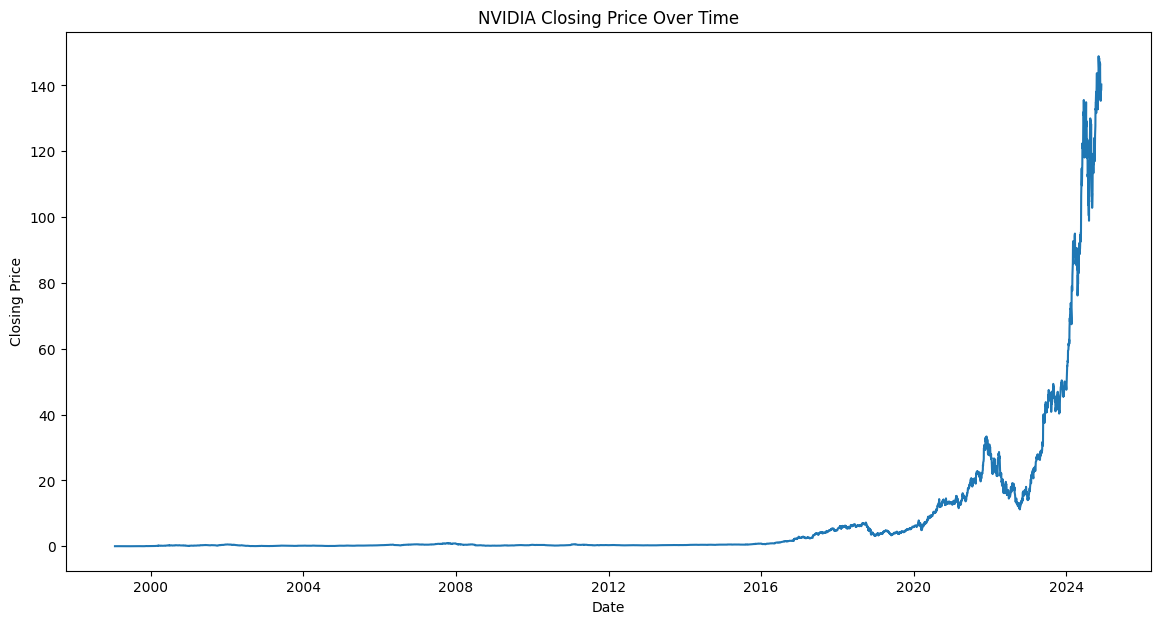

In [ ]:
plt.figure(figsize=(14, 7))
sns.lineplot(data=df, x='Date', y='Close')
plt.title('NVIDIA Closing Price Over Time')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.show()

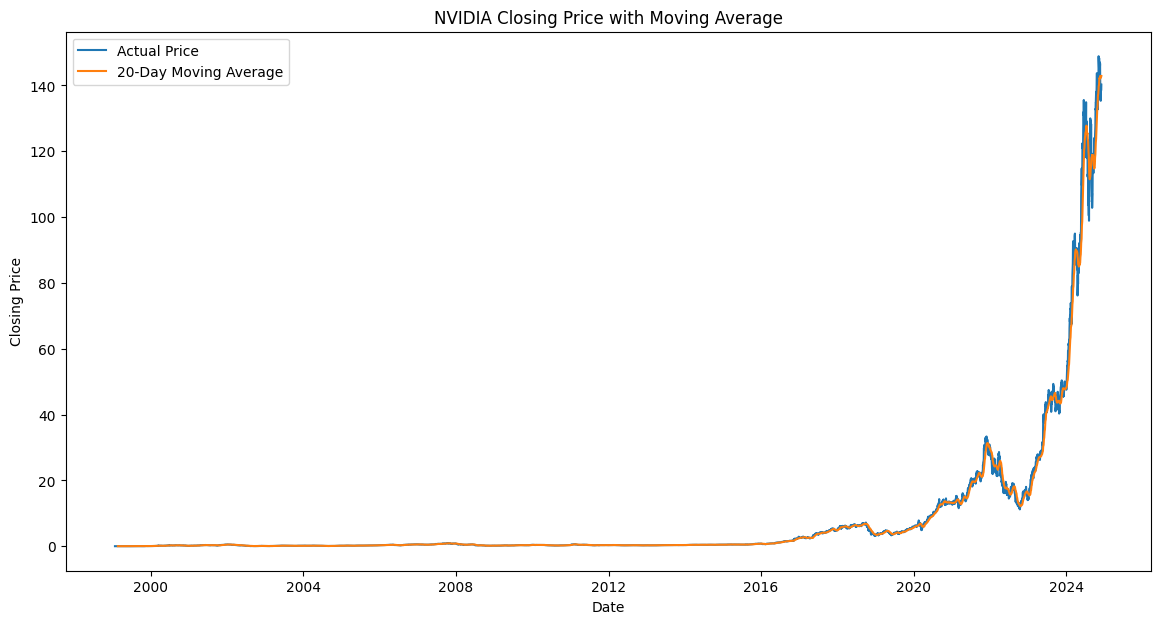

In [ ]:
df['Moving_Avg_20'] = df['Close'].rolling(window=20).mean()

plt.figure(figsize=(14, 7))
sns.lineplot(data=df, x='Date', y='Close', label='Actual Price')
sns.lineplot(data=df, x='Date', y='Moving_Avg_20', label='20-Day Moving Average')
plt.title('NVIDIA Closing Price with Moving Average')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.show()


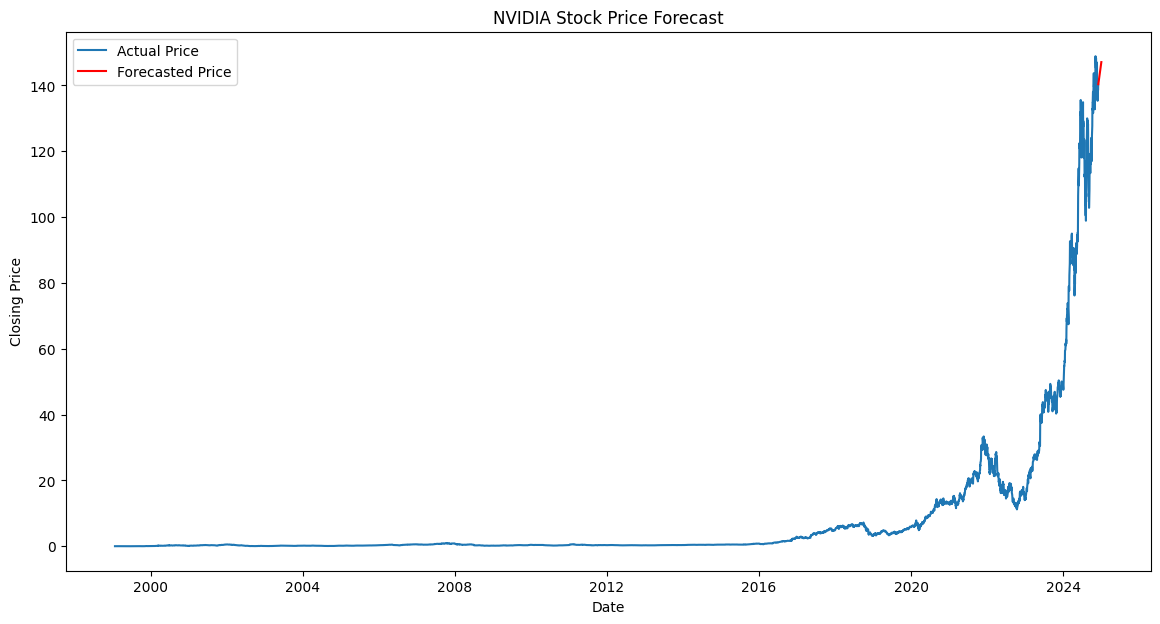

In [ ]:
from statsmodels.tsa.holtwinters import Expon

# Apply Exponential Smoothing
model = ExponentialSmoothing(df['Close'], trend='add', seasonal=None)
fit = model.fit()

# Forecast next 30 days
forecast = fit.forecast(steps=30)

# Extend the date range for plotting
future_dates = pd.date_range(start=df['Date'].iloc[-1], periods=31, freq='D')[1:]

# Plot historical and forecasted prices
plt.figure(figsize=(14, 7))
sns.lineplot(data=df, x='Date', y='Close', label='Actual Price')
plt.plot(future_dates, forecast, label='Forecasted Price', color='red')
plt.title('NVIDIA Stock Price Forecast')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.show()


In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df['Normalized_Close'] = scaler.fit_transform(df[['Close']])

##Feature Engineering

In [ ]:
#Adding Moving Averages
df['MA_20'] = df['Close'].rolling(window=20).mean()
df['MA_50'] = df['Close'].rolling(window=50).mean()

# Fill NaN values caused by rolling windows
df.fillna(method='bfill', inplace=True)


In [ ]:
from sklearn.model_selection import train_test_split

features = ['Normalized_Close', 'MA_20', 'MA_50']
X = df[features]
y = df['Normalized_Close']
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Train a Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')


Mean Squared Error: 1.1454895634835306e-32


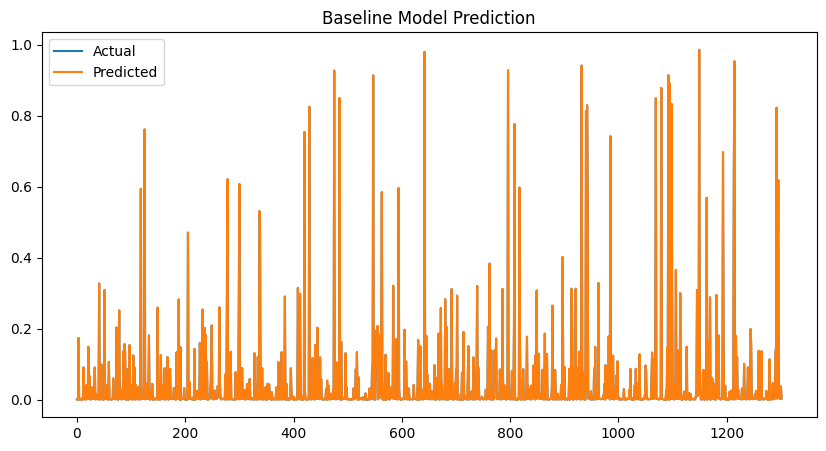

In [ ]:
import matplotlib.pyplot as plt

# Plot actual vs predicted values
plt.figure(figsize=(10, 5))
plt.plot(y_test.values, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.title('Baseline Model Prediction')
plt.show()


In [ ]:
# Split data into training and test sets
train_data = df[df['Date'] < '2024-01-01']  # Adjust based on your dataset timeline
test_data = df[df['Date'] >= '2024-01-01']


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Prepare features and target
X_train = train_data[['MA_20', 'MA_50']]  # Example features
y_train = train_data['Close']
X_test = test_data[['MA_20', 'MA_50']]
y_test = test_data['Close']

# Train model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Make predictions
y_pred_lr = lr_model.predict(X_test)

# Evaluate performance
mse_lr = mean_squared_error(y_test, y_pred_lr)
mae_lr = mean_absolute_error(y_test, y_pred_lr)
print(f"Linear Regression - MSE: {mse_lr}, MAE: {mae_lr}")


Linear Regression - MSE: 64.70727984675091, MAE: 6.66585427774508


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Reshape input for LSTM (3D: samples, time steps, features)
X_train_lstm = X_train.values.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test_lstm = X_test.values.reshape(X_test.shape[0], 1, X_test.shape[1])

# Define LSTM model
lstm_model = Sequential([
    LSTM(50, activation='relu', input_shape=(1, X_train.shape[1])),
    Dense(1)
])
lstm_model.compile(optimizer='adam', loss='mse')

# Train model
lstm_model.fit(X_train_lstm, y_train, epochs=10, batch_size=32, verbose=1)

# Predict and evaluate
y_pred_lstm = lstm_model.predict(X_test_lstm)
mse_lstm = mean_squared_error(y_test, y_pred_lstm)
mae_lstm = mean_absolute_error(y_test, y_pred_lstm)
print(f"LSTM - MSE: {mse_lstm}, MAE: {mae_lstm}")


Epoch 1/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 25.0115
Epoch 2/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.8539
Epoch 3/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.6449
Epoch 4/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.5654
Epoch 5/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4547
Epoch 6/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.3907
Epoch 7/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4094
Epoch 8/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4123
Epoch 9/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3841
Epoch 10/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3574
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
LSTM - MSE: 254.04241097859463, MAE: 14.11289323143693


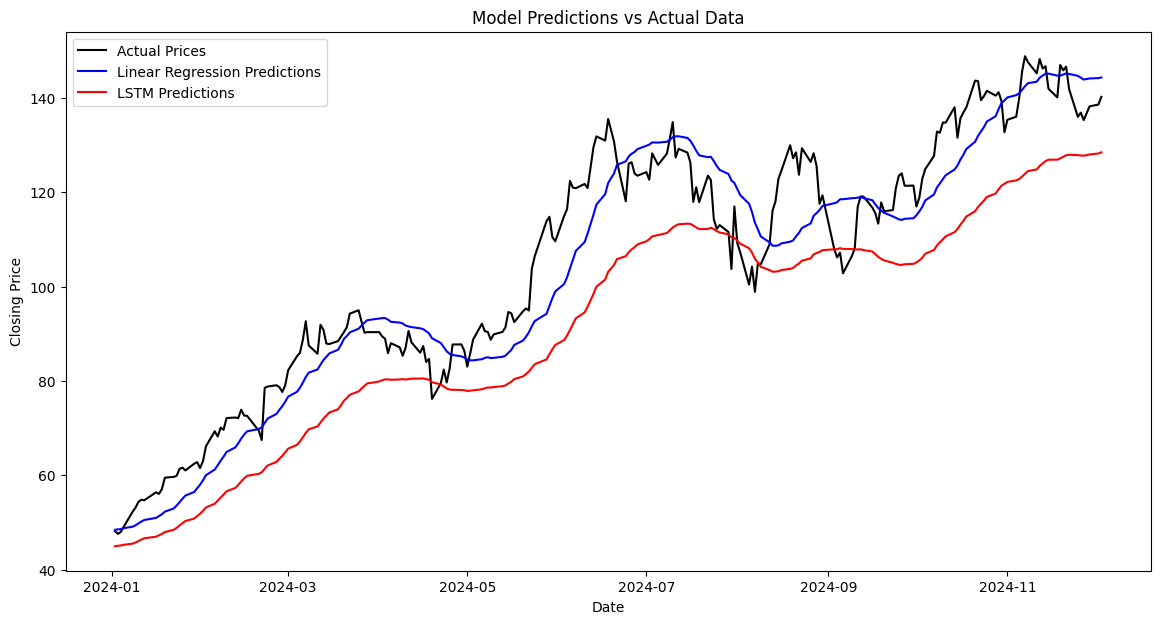

In [ ]:
import matplotlib.pyplot as plt

# Plot actual vs predicted for all models
plt.figure(figsize=(14, 7))

# Actual Data
plt.plot(test_data['Date'], y_test, label='Actual Prices', color='black')

# Predictions
plt.plot(test_data['Date'], y_pred_lr, label='Linear Regression Predictions', color='blue')
plt.plot(test_data['Date'], y_pred_lstm, label='LSTM Predictions', color='red')

plt.title('Model Predictions vs Actual Data')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.show()


In [ ]:
!pip install transformers
!pip install torch
!pip install pandas
!pip install googletrans==4.0.0-rc1

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.1/55.1 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.0/65.0 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 46.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 4.2 MB/s eta 0:00:00
  Created wheel for googletrans: filename=googletrans-4.0.0rc1-py3-none-any.whl size=17397 sha256=852965d6ec48a589ddf073f1af2621f676db5cb41e72c970c0312ec16b8210be
  Stored in directory: /root/.cache/pip/wheels/c0/59/9f/7372f0cf70160fe61b528532e1a7c8498c4becd6bcffb022de
Successfully built googletrans
  Attempting uninstall: h11
    Found existing installation: h11 0.14.0
    Uninstalling h11-0.14.0:
      Suc

In [ ]:
# Load the Nvidia news dataset
df2 = pd.read_csv('dataset/nvidia_sentimental_analisis.csv')

# Display the first few rows of the dataset
print(df2[df2['Summary'] == ''].shape[0])


0


In [ ]:
from googletrans import Translator

# Initialize the translator
translator = Translator()

# Function to translate text to English
def translate_text(text):
    if text is None or text == '':
        return ''
    try:
        # Split the text into chunks if it's too long
        max_length = 5000  # Set a limit for the text length
        if len(text) > max_length:
            chunks = [text[i:i + max_length] for i in range(0, len(text), max_length)]
            translated_chunks = [translator.translate(chunk, src='pt', dest='en').text for chunk in chunks]
            return ' '.join(translated_chunks)
            #takes 20 miniutes+++
        else:
            translated = translator.translate(text, src='pt', dest='en')
            return translated.text
    except Exception as e:
        print(f"Error translating text: {e}")
        return text  # Return the original text in case of error

# Apply translation to all headlines
df2['Summary'] = df2['Summary'].apply(translate_text)
df2.head()


,Date,Summary,sentiment_rf,sentiment_nn
0,2024-06-14,New York scholarships closed without a single ...,neutral,positive
1,2024-06-14,"US action rates were retreat today, with S&P 5...",positive,positive
2,2024-06-14,Tesla (Nasdaq: TSLA) shareholders showed suppo...,neutral,neutral
3,2024-06-13,"In a recent movement, Mark A. Stevens, directo...",neutral,neutral
4,2024-06-13,(Bloomberg)-Broadcom has experienced a signifi...,neutral,neutral


In [ ]:
from google.colab import files

# Save the DataFrame to a CSV file
df2.to_csv('translated_data.csv', index=False)

# Download the CSV file
files.download('translated_data.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification
import torch

# Load the FinBERT model and tokenizer
model_name = "yiyanghkust/finbert-tone"
model = BertForSequenceClassification.from_pretrained(model_name)
tokenizer = BertTokenizer.from_pretrained(model_name)

config.json:   0%|          | 0.00/533 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/439M [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/226k [00:00<?, ?B/s]

In [ ]:
# Function to get sentiment for a single headline
def get_sentiment(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)

    # Get the model's prediction
    with torch.no_grad():
        outputs = model(**inputs)

    # Get the sentiment class: 0 (negative), 1 (positive), 2 (neutral)
    sentiment = torch.argmax(outputs.logits, dim=-1).item()

    if sentiment == 0:
        return "negative"
    elif sentiment == 1:
        return "positive"
    else:
        return "neutral"

#takes 15 minutes +++
# Apply sentiment analysis to all headlines
df2['Sentiment'] = df2['Summary'].apply(get_sentiment)

# Show the dataset with sentiment results
df2.head()


,Date,Summary,sentiment_rf,sentiment_nn,Sentiment
0,2024-06-14,New York scholarships closed without a single ...,neutral,positive,positive
1,2024-06-14,"US action rates were retreat today, with S&P 5...",positive,positive,negative
2,2024-06-14,Tesla (Nasdaq: TSLA) shareholders showed suppo...,neutral,neutral,positive
3,2024-06-13,"In a recent movement, Mark A. Stevens, directo...",neutral,neutral,negative
4,2024-06-13,(Bloomberg)-Broadcom has experienced a signifi...,neutral,neutral,positive


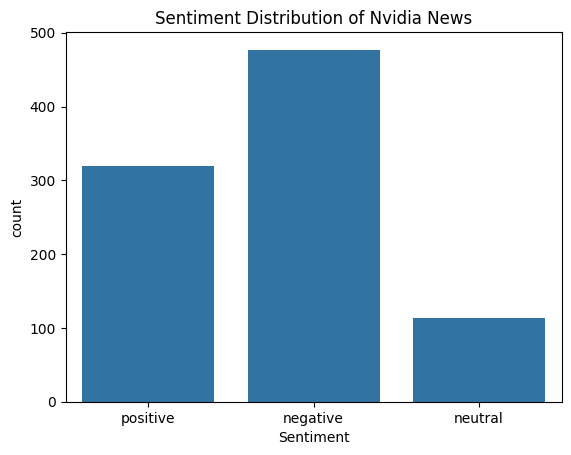

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot sentiment distribution
sns.countplot(x='Sentiment', data=df2)
plt.title('Sentiment Distribution of Nvidia News')
plt.show()


In [ ]:
df2[['Date', 'Summary', 'Sentiment']]

,Date,Summary,Sentiment
0,2024-06-14,New York scholarships closed without a single ...,positive
1,2024-06-14,"US action rates were retreat today, with S&P 5...",negative
2,2024-06-14,Tesla (Nasdaq: TSLA) shareholders showed suppo...,positive
3,2024-06-13,"In a recent movement, Mark A. Stevens, directo...",negative
4,2024-06-13,(Bloomberg)-Broadcom has experienced a signifi...,positive
...,...,...,...
906,2016-10-24,Investing.com - E.U.A. - The actions closed on...,negative
907,2016-08-12,Investing.com - U.U. - The actions closed unch...,neutral
908,2016-05-13,Investing.com - E.U.A. - The actions crashed i...,negative
909,2015-11-06,Investing.com - E.U.A. - The actions closed un...,negative


In [ ]:
import pandas as pd

file_path = 'translated_data.csv'

df2 = pd.read_csv(file_path)
df2['Date'] = pd.to_datetime(df2['Date'])

# Create a mapping for sentiment scores
sentiment_mapping = {'negative': -1, 'neutral': 0, 'positive': 1}
df2['Sentiment_Score'] = df2['Sentiment'].map(sentiment_mapping)

# Group by date and calculate the mean sentiment score
daily_sentiment = df2.groupby('Date')['Sentiment_Score'].mean().reset_index()

# Print the resulting DataFrame
daily_sentiment

,Date,Sentiment_Score
0,2015-08-06,-1.000000
1,2015-11-06,-1.000000
2,2016-05-13,-1.000000
3,2016-08-12,0.000000
4,2016-10-24,-1.000000
...,...,...
482,2024-06-10,-0.714286
483,2024-06-11,-0.600000
484,2024-06-12,0.000000
485,2024-06-13,-0.500000


In [ ]:
merged_df = pd.merge(df, daily_sentiment, on='Date', how='left')

merged_df['Sentiment_Score'].fillna(0, inplace=True)

merged_df[merged_df['Sentiment_Score'] > 0]

,Date,Open,High,Low,Close,Adj Close,Volume,Sentiment_Score
4639,2017-06-29,3.765000,3.768000,3.602000,3.667000,3.300880,1064424000,1.000000
4653,2017-07-20,4.148250,4.187750,4.097750,4.187500,3.769412,699596000,1.000000
4710,2017-10-10,4.785750,4.823750,4.681500,4.723250,4.289405,974876000,1.000000
4729,2017-11-06,5.180000,5.249500,5.167500,5.240750,4.759371,389944000,1.000000
4853,2018-05-07,6.082250,6.274750,6.072250,6.217000,5.720955,687616000,1.000000
...,...,...,...,...,...,...,...,...
6374,2024-05-22,95.459000,96.019997,93.249001,94.949997,94.949997,548648000,0.100000
6375,2024-05-23,102.028000,106.320000,101.519997,103.799004,103.799004,835065000,0.230769
6376,2024-05-24,104.448997,106.474998,103.000000,106.469002,106.469002,429494000,0.428571
6383,2024-06-05,118.371002,122.448997,117.468002,122.440002,122.440002,528402000,0.400000


In [ ]:
from google.colab import files

# Save the DataFrame to a CSV file
merged_df.to_csv('final_data.csv', index=False)

# Download the CSV file
files.download('final_data.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [1]:
import pandas as pd

file_path = 'final_data.csv'

df = pd.read_csv(file_path)

df.head()


,Date,Open,High,Low,Close,Adj Close,Volume,Sentiment_Score
0,1999-01-22,0.043750,0.048828,0.038802,0.041016,0.017325,2714688000,0.0
1,1999-01-25,0.044271,0.045833,0.041016,0.045313,0.019140,510480000,0.0
2,1999-01-26,0.045833,0.046745,0.041146,0.041797,0.017655,343200000,0.0
3,1999-01-27,0.041927,0.042969,0.039583,0.041667,0.017600,244368000,0.0
4,1999-01-28,0.041667,0.041927,0.041276,0.041536,0.017544,227520000,0.0


In [33]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

df = df.sort_values('Date')

df = df[df['Date'] > '2017-06-29']

df.reset_index(drop=True, inplace=True)

#Adding Moving Averages
df['MA_20'] = df['Close'].rolling(window=20).mean()
df['MA_50'] = df['Close'].rolling(window=50).mean()

# Fill NaN values caused by rolling windows
df.fillna(method='bfill', inplace=True)

# Scale down the sentiment
df['Sentiment_Score'] = df['Sentiment_Score'] / 1000

# Alternatively, scale all features to a similar range
scaler = MinMaxScaler()
df[['MA_20', 'MA_50', 'Sentiment_Score']] = scaler.fit_transform(df[['MA_20', 'MA_50', 'Sentiment_Score']])


# Select features and target for prediction
features = ['MA_20', 'MA_50', 'Sentiment_Score']  # Features
target = 'Close'  # Target variable

# Train-test split
X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

<ipython-input-33-61df4ee47b79>:15: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)


In [34]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Initialize and train the model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Make predictions
y_pred_lr = lr_model.predict(X_test)

# Evaluate performance
mse_lr = mean_squared_error(y_test, y_pred_lr)
mae_lr = mean_absolute_error(y_test, y_pred_lr)

print(f"Linear Regression - MSE: {mse_lr}, MAE: {mae_lr}")


Linear Regression - MSE: 41.0805800246848, MAE: 4.812320294382015


In [35]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Reshape data for LSTM
X_train_lstm = np.array(X_train).reshape(X_train.shape[0], 1, X_train.shape[1])
X_test_lstm = np.array(X_test).reshape(X_test.shape[0], 1, X_test.shape[1])

# Define the LSTM model
lstm_model = Sequential([
    LSTM(50, activation='relu', input_shape=(1, X_train.shape[1])),
    Dense(1)
])

# Compile the model
lstm_model.compile(optimizer='adam', loss='mse')

# Train the model
lstm_model.fit(X_train_lstm, y_train, epochs=100, batch_size=32, verbose=1)

# Make predictions
y_pred_lstm = lstm_model.predict(X_test_lstm)

# Evaluate performance
mse_lstm = mean_squared_error(y_test, y_pred_lstm)
mae_lstm = mean_absolute_error(y_test, y_pred_lstm)

print(f"LSTM - MSE: {mse_lstm}, MAE: {mae_lstm}")


Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 215.8052
Epoch 2/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 205.4182
Epoch 3/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 192.1429
Epoch 4/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 189.8774
Epoch 5/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 166.1168
Epoch 6/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 151.2970
Epoch 7/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 116.2199
Epoch 8/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 98.7645 
Epoch 9/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 85.8469
Epoch 10/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 62.5715
Epoch 11/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 51.0909
Epoch 12/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 45.4397
Epoch 13/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 48.5200
Epoch 14/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 43.4600
Epoch 15/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 

In [36]:
print("Performance Comparison:")
print(f"Linear Regression - MSE: {mse_lr}, MAE: {mae_lr}")
print(f"LSTM - MSE: {mse_lstm}, MAE: {mae_lstm}")


Performance Comparison:
Linear Regression - MSE: 41.0805800246848, MAE: 4.812320294382015
LSTM - MSE: 99.68288856711371, MAE: 7.567363035232625


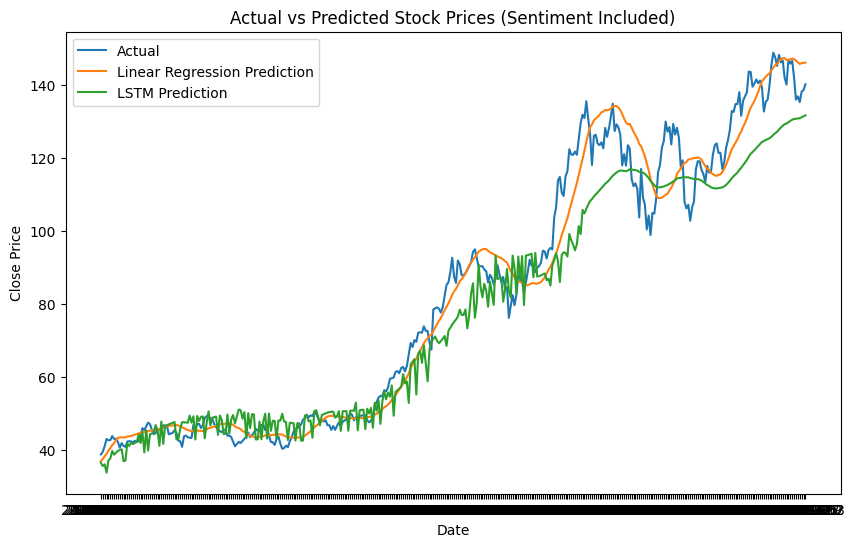

In [37]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(df['Date'][-len(y_test):], y_test, label='Actual')
plt.plot(df['Date'][-len(y_test):], y_pred_lr, label='Linear Regression Prediction')
plt.plot(df['Date'][-len(y_test):], y_pred_lstm, label='LSTM Prediction')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Actual vs Predicted Stock Prices (Sentiment Included)')
plt.show()


In [38]:
# Select features and target for prediction
features = ['MA_20', 'MA_50']  # Features
target = 'Close'  # Target variable

# Train-test split
X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [39]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Initialize and train the model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Make predictions
y_pred_lr = lr_model.predict(X_test)

# Evaluate performance
mse_lr = mean_squared_error(y_test, y_pred_lr)
mae_lr = mean_absolute_error(y_test, y_pred_lr)

print(f"Linear Regression - MSE: {mse_lr}, MAE: {mae_lr}")


Linear Regression - MSE: 41.143630773045786, MAE: 4.819484551297911


In [40]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Reshape data for LSTM
X_train_lstm = np.array(X_train).reshape(X_train.shape[0], 1, X_train.shape[1])
X_test_lstm = np.array(X_test).reshape(X_test.shape[0], 1, X_test.shape[1])

# Define the LSTM model
lstm_model = Sequential([
    LSTM(50, activation='relu', input_shape=(1, X_train.shape[1])),
    Dense(1)
])

# Compile the model
lstm_model.compile(optimizer='adam', loss='mse')

# Train the model
lstm_model.fit(X_train_lstm, y_train, epochs=100, batch_size=32, verbose=1)

# Make predictions
y_pred_lstm = lstm_model.predict(X_test_lstm)

# Evaluate performance
mse_lstm = mean_squared_error(y_test, y_pred_lstm)
mae_lstm = mean_absolute_error(y_test, y_pred_lstm)

print(f"LSTM - MSE: {mse_lstm}, MAE: {mae_lstm}")


Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - loss: 209.2503
Epoch 2/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 209.5864
Epoch 3/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 206.6029
Epoch 4/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 186.2961
Epoch 5/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 188.4535
Epoch 6/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 170.5404
Epoch 7/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 157.8549
Epoch 8/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 128.4125
Epoch 9/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 119.3634
Epoch 10/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 98.8260 
Epoch 11/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 85.1069
Epoch 12/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 64.2737
Epoch 13/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 54.3217
Epoch 14/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 42.6014
Epoch 15/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss

In [41]:
print("Performance Comparison:")
print(f"Linear Regression - MSE: {mse_lr}, MAE: {mae_lr}")
print(f"LSTM - MSE: {mse_lstm}, MAE: {mae_lstm}")

Performance Comparison:
Linear Regression - MSE: 41.143630773045786, MAE: 4.819484551297911
LSTM - MSE: 376.2386860611492, MAE: 14.56738592341622


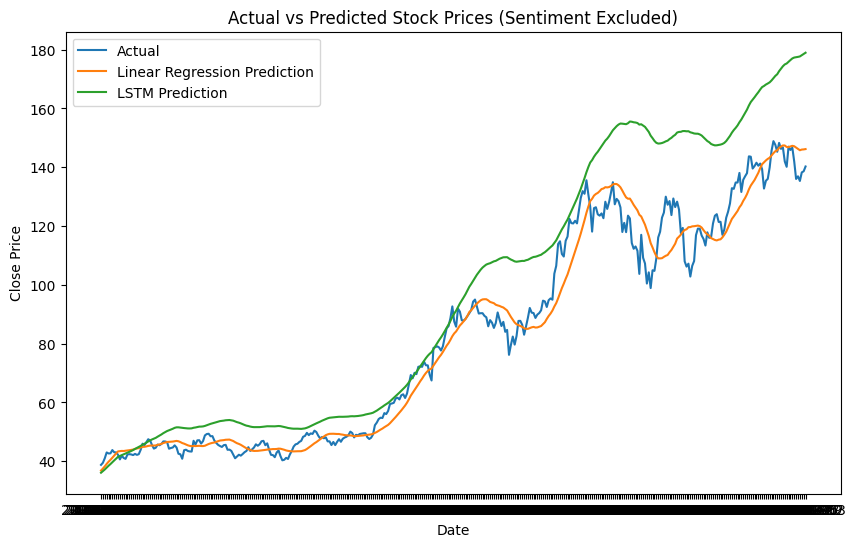

In [42]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(df['Date'][-len(y_test):], y_test, label='Actual')
plt.plot(df['Date'][-len(y_test):], y_pred_lr, label='Linear Regression Prediction')
plt.plot(df['Date'][-len(y_test):], y_pred_lstm, label='LSTM Prediction')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Actual vs Predicted Stock Prices (Sentiment Excluded)')
plt.show()
